In [18]:
from habitat_dataset import get_dataset, HabitatDataset

from pathlib import Path
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd

transform_ = transforms.ToPILImage()
dataset = HabitatDataset('test_ppo_data/train/0001')

In [30]:
import torch.nn as nn
from resnet import ResnetBase

def spatial_softmax_base():
    return nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, 3, 2, 1, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
            nn.ReLU(True)
    )


class Network(ResnetBase):
    def __init__(self, resnet_model='resnet34', **resnet_kwargs):
        resnet_kwargs['input_channel'] = resnet_kwargs.get('input_channel', 3)

        super().__init__(resnet_model, **resnet_kwargs)

        self.normalize = nn.BatchNorm2d(resnet_kwargs['input_channel'])
        self.deconv = spatial_softmax_base()
        self.extract = nn.Sequential(
                nn.BatchNorm2d(64),
                nn.Conv2d(64, 5, 1, 1, 0))#,
                #common.SpatialSoftmax(temperature))
        
        self.fc1 = nn.Linear(64, 1)
        self.fc2 = nn.Linear(64, 1)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.normalize(x)
        x = self.conv(x)
        x = self.deconv(x)

        x = self.fc2(self.fc1(self.extract(x)).squeeze()).squeeze()
        print(x.shape)
        return self.softmax(x)

net = Network(resnet_model='resnet34')

In [31]:
net((dataset[5][0]).repeat(4,1,1,1))

torch.Size([4, 5])


tensor([[0.1731, 0.2320, 0.1751, 0.2130, 0.2067],
        [0.1731, 0.2320, 0.1751, 0.2130, 0.2067],
        [0.1731, 0.2320, 0.1751, 0.2130, 0.2067],
        [0.1731, 0.2320, 0.1751, 0.2130, 0.2067]], grad_fn=<SoftmaxBackward>)

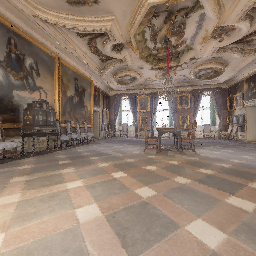

In [25]:
transform_(dataset[5][0])

In [3]:
train_dataset, test_dataset = get_dataset('test_ppo_data')

train: 480
val: 109


In [4]:
criterion = torch.nn.L1Loss(reduction='none')

In [14]:
action = torch.zeros(128, 5)
_action = torch.zeros(128, 5)
criterion(action,_action).mean((1,1))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])